In [1]:
import matplotlib
import matplotlib.pyplot as plt
#from labellines import labelLine, labelLines
# import seaborn as sns
import os
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split


Compute Signal efficiency, Background rejection, data reduction

Physical hist content:  [1.46069e+05 3.10224e+05 3.13378e+05 2.70617e+05 2.16202e+05 1.69019e+05
 1.28895e+05 9.88210e+04 7.53290e+04 5.80740e+04 4.47350e+04 3.53160e+04
 2.78370e+04 2.24110e+04 1.81340e+04 1.53540e+04 1.30710e+04 1.11400e+04
 9.39000e+03 8.01900e+03 6.74000e+03 5.81300e+03 4.89000e+03 4.21900e+03
 3.54600e+03 3.03500e+03 2.74300e+03 2.26400e+03 1.90200e+03 1.68200e+03
 1.38400e+03 1.26400e+03 1.17100e+03 9.49000e+02 8.68000e+02 7.46000e+02
 6.51000e+02 5.73000e+02 5.34000e+02 4.39000e+02 4.03000e+02 3.97000e+02
 3.22000e+02 2.95000e+02 2.93000e+02 2.61000e+02 2.31000e+02 2.28000e+02
 1.58000e+02 1.80000e+02]
2040216
2040216 2040216 2040216


,pt,predict,true
0,2.5575,0,0
1,1.7065,0,0
2,1.9615,0,0
3,1.5965,0,0
4,-2.5775,0,0


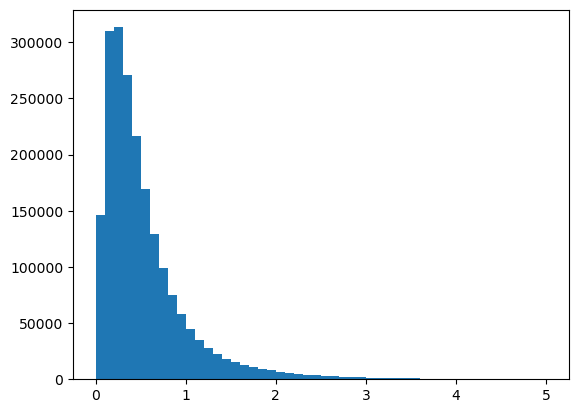

In [2]:
# threshold = 0.2
# sensor_geom = sensor_iter
print("=============================")
# print("Analyzing run "+str(run_iter)+": Sensor geometry ",sensor_geom," at pT boundary = ",threshold)
train_dir = '/uscms/home/bweiss/nobackup/smart-pixels/dataset_2s_50x12P5_parquets/train_test_2s'

mergePosNeg = pd.read_csv(os.path.join(train_dir, "FullTestData.csv"))

# True pT distribution (physical no sign)
h_physical = plt.hist(abs(mergePosNeg['pt']),bins=np.linspace(0,5,51),histtype='stepfilled');

# weight per pT bin
print("Physical hist content: ",h_physical[0])
w_physical = h_physical[0]/np.sum(h_physical[0])

df1 = pd.read_csv(os.path.join(train_dir,'TestSetPt.csv'))
print(len(df1))
# _, df1 = train_test_split(df1,test_size = 0.20, shuffle=False)
df1 = df1.reset_index(drop=True)
df2 = pd.read_csv('./predictionsFiles_NoNoise.csv')
df3 = pd.read_csv('./testResults_NoNoise.csv')
df2.columns.values[0] = "predict"
df3.columns.values[0] = "true"
print(len(df1),len(df2), len(df3))
df2['predict'] = df2['predict'].astype(int)
concatenate = pd.concat([df1,df2, df3], axis=1)
concatenate.head()

In [3]:
print(concatenate[-20:-1])
print(concatenate[:20])

Nlow=len(concatenate[abs(concatenate['pt'])<0.2])
Nbkg=len(concatenate[ (abs(concatenate['pt'])<2) & (abs(concatenate['pt'])>0.2)] )
print(Nlow, Nbkg, Nlow/Nbkg)


             pt  predict  true
2040196 -0.2095        1     0
2040197 -0.7685        1     0
2040198 -0.3145        1     0
2040199  0.8455        0     0
2040200  0.2005        2     0
2040201 -0.4935        0     0
2040202 -0.2645        1     0
2040203 -0.6705        0     0
2040204  0.0595        2     2
2040205  0.1245        2     2
2040206  0.9485        0     0
2040207  0.2595        0     0
2040208 -0.3435        1     0
2040209  0.7335        0     0
2040210 -0.2065        1     0
2040211 -0.5375        1     0
2040212  0.3355        2     0
2040213 -0.4005        0     0
2040214 -0.3685        0     0
        pt  predict  true
0   2.5575        0     0
1   1.7065        0     0
2   1.9615        0     0
3   1.5965        0     0
4  -2.5775        0     0
5  -4.9335        0     0
6   1.7225        0     0
7   1.7195        1     0
8  -2.9995        0     0
9   1.5455        0     0
10  2.2055        0     0
11 -1.8905        0     0
12 -2.7705        0     0
13  1.9605      

Unphysical hist content:  [1.46069e+05 3.10224e+05 3.13378e+05 2.70617e+05 2.16202e+05 1.69019e+05
 1.28895e+05 9.88210e+04 7.53290e+04 5.80740e+04 4.47350e+04 3.53160e+04
 2.78370e+04 2.24110e+04 1.81340e+04 1.53540e+04 1.30710e+04 1.11400e+04
 9.39000e+03 8.01900e+03 6.74000e+03 5.81300e+03 4.89000e+03 4.21900e+03
 3.54600e+03 3.03500e+03 2.74300e+03 2.26400e+03 1.90200e+03 1.68200e+03
 1.38400e+03 1.26400e+03 1.17100e+03 9.49000e+02 8.68000e+02 7.46000e+02
 6.51000e+02 5.73000e+02 5.34000e+02 4.39000e+02 4.03000e+02 3.97000e+02
 3.22000e+02 2.95000e+02 2.93000e+02 2.61000e+02 2.31000e+02 2.28000e+02
 1.58000e+02 1.80000e+02]
r =  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


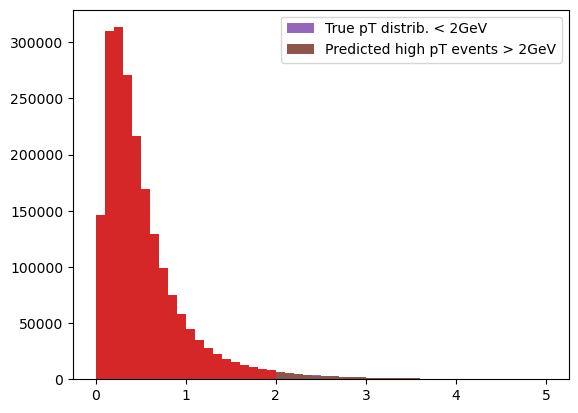

nse =  48181.0
Signal efficiency = 93.37%


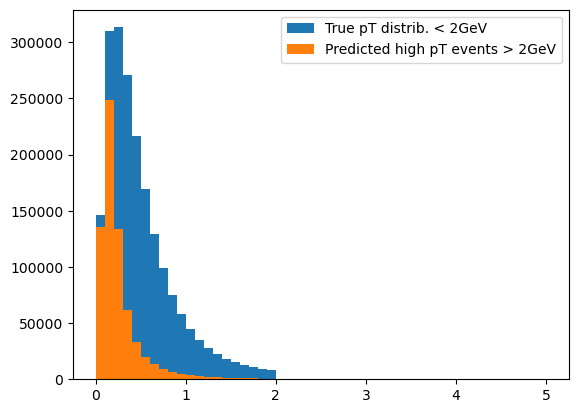

Background rejection = 34.25%


/tmp/ipykernel_576/1831518710.py:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


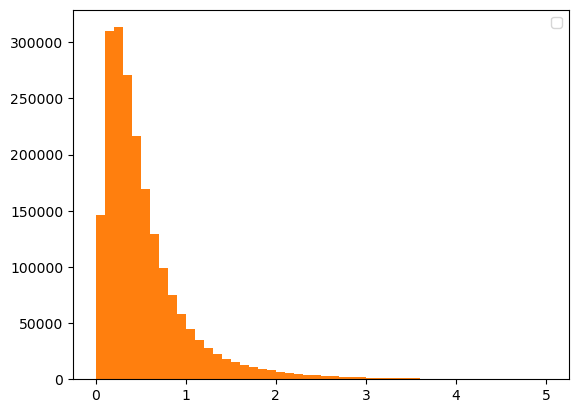

Data reduction = 33.59%


NameError: name 'run_iter' is not defined

In [4]:
# Unphysical pT distribution (no sign)
h_unphysical = plt.hist(abs(concatenate['pt']),bins=np.linspace(0,5,51),histtype='stepfilled');
w_unphysical = h_unphysical[0]/np.sum(h_unphysical[0])
print("Unphysical hist content: ",h_unphysical[0])

# weight each bin up by physical weight, down by unphysical weight
r = w_physical/w_unphysical
print("r = ",r)

# Unphysical pT distribution of rejected clusters only
h_reject = plt.hist(abs(concatenate[concatenate['predict']>0]['pt']),bins=np.linspace(0,5,51))
np.sum(h_reject[0]*r)/np.sum(h_unphysical[0]*r)

# Unphysical pT distribution of true low pT clusters
h_lowpt = plt.hist(abs(concatenate[concatenate['true']>0]['pt']),bins=np.linspace(0,5,51))
np.sum(h_lowpt[0]*r)/np.sum(h_unphysical[0]*r)

# Unphysical pT distribution of true low pT clusters
h_lowpt = plt.hist(abs(concatenate[abs(concatenate['pt'])<2]['pt']),bins=np.linspace(0,5,51))
np.sum(h_lowpt[0]*r)/np.sum(h_unphysical[0]*r)

len(mergePosNeg[abs(mergePosNeg['pt'])<2.0])/len(mergePosNeg['pt'])

h_trulyEfficient = plt.hist(abs(concatenate[abs(concatenate['pt'])>2]['pt']),bins=np.linspace(0,5,51),histtype='stepfilled', label='True pT distrib. < 2GeV');
h_efficiency = plt.hist(abs(concatenate[(abs(concatenate['pt'])>2) & (concatenate['predict']==0)]['pt']),bins=np.linspace(0,5,51), label='Predicted high pT events > 2GeV')
plt.legend()
plt.show()
sig_eff = np.sum(h_efficiency[0]*r)/np.sum(h_trulyEfficient[0]*r)
Nse = np.sum(h_trulyEfficient[0])
print("nse = ",Nse)
sig_eff_err = np.sqrt(sig_eff*(1-sig_eff)/Nse)
print("Signal efficiency = {:.2f}%".format(100*np.sum(h_efficiency[0]*r)/np.sum(h_trulyEfficient[0]*r)))


h_trulyRejected = plt.hist(abs(concatenate[abs(concatenate['pt'])<2]['pt']),bins=np.linspace(0,5,51),histtype='stepfilled', label='True pT distrib. < 2GeV');
h_rejected = plt.hist(abs(concatenate[(abs(concatenate['pt'])<2) & (concatenate['predict']>0)]['pt']),bins=np.linspace(0,5,51), label='Predicted high pT events > 2GeV')
plt.legend()
plt.show()
bg_rej = np.sum(h_rejected[0]*r)/np.sum(h_trulyRejected[0]*r)
Nbg = np.sum(h_trulyRejected[0])
bg_rej_err = np.sqrt(bg_rej*(1-bg_rej)/Nbg)
print("Background rejection = {:.2f}%".format(100*np.sum(h_rejected[0]*r)/np.sum(h_trulyRejected[0]*r)))

# Data reduction value
h_reduction = plt.hist(abs(concatenate[concatenate['predict']>0]['pt']),bins=np.linspace(0,5,51))
h_unphysical = plt.hist(abs(concatenate['pt']),bins=np.linspace(0,5,51),histtype='stepfilled')
plt.legend()
plt.show()
dat_red = np.sum(h_reduction[0]*r)/np.sum(h_unphysical[0]*r)
Ndr = np.sum(h_unphysical[0])
dat_red_err = np.sqrt(dat_red*(1-dat_red)/Ndr)
print("Data reduction = {:.2f}%".format(100*np.sum(h_reduction[0]*r)/np.sum(h_unphysical[0]*r)))

with open('./final_results_NoNoise.txt', 'a') as file:
    file.write(+str(run_iter)+','+str(sig_eff)+','+str(sig_eff_err)+','+str(bg_rej)+','+str(bg_rej_err)+','+ str(dat_red)+','+str(dat_red_err)+'\n')

Original code (not made by Ben)

In [ ]:
# results_dir = 'results_7s'
# dataset_name = 'dataset_7s'
results_dir = 'results_9s_600NoiseThresh'
dataset_name = 'dataset_9s_600NoiseThresh'
f = open('./'+results_dir+'/final_results.txt', "w+")
f.seek(0)
f.truncate()
# mergePosNeg = pd.concat([big_df_labels, big_df_labels2])
for run_iter in range(10):
    for sensor_iter in ['50x12P5_0fb', '50x12P5_370fb', '50x12P5_1100fb', '100x25x150_0fb', '100x25x150_370fb', '100x25x150_1100fb']:
    # for sensor_iter in ['50x10', '50x12P5', '50x15', '50x20', '50x25', '100x25', '100x25x150']:
        # for thresh_iter in [0.1, 0.125, 0.15, 0.175, 0.2, 0.3, 0.4, 0.5]:
        for thresh_iter in [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]:
            threshold = thresh_iter
            sensor_geom = sensor_iter
            print("=============================")
            print("Analyzing run "+str(run_iter)+": Sensor geometry ",sensor_geom," at pT boundary = ",threshold)
            mergePosNeg = pd.read_csv(dataset_name+"/FullTestData_"+sensor_geom+"_0P"+str(threshold - int(threshold))[2:]+"thresh.csv")
            
            # True pT distribution (physical no sign)
            h_physical = plt.hist(abs(mergePosNeg['pt']),bins=np.linspace(0,5,51),histtype='stepfilled');

            # weight per pT bin
            print("Physical hist content: ",h_physical[0])
            w_physical = h_physical[0]/np.sum(h_physical[0])
            
            df1 = pd.read_csv('./'+dataset_name+'/TestSetPt_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            df2 = pd.read_csv('./'+results_dir+'/predictionsFiles_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh_run'+str(run_iter)+'.csv')
            df3 = pd.read_csv('./'+results_dir+'/testResults_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh_run'+str(run_iter)+'.csv')
            df2.columns.values[0] = "predict"
            df3.columns.values[0] = "true"
            df2['predict'] = df2['predict'].astype(int)
            concatenate = pd.concat([df1,df2, df3], axis=1)
            concatenate.head()
            
            # Unphysical pT distribution (no sign)
            h_unphysical = plt.hist(abs(concatenate['pt']),bins=np.linspace(0,5,51),histtype='stepfilled');
            w_unphysical = h_unphysical[0]/np.sum(h_unphysical[0])
            print("Unphysical hist content: ",h_unphysical[0])
            
            # weight each bin up by physical weight, down by unphysical weight
            r = w_physical/w_unphysical
            print("r = ",r)
            
            # Unphysical pT distribution of rejected clusters only
            h_reject = plt.hist(abs(concatenate[concatenate['predict']>0]['pt']),bins=np.linspace(0,5,51))
            np.sum(h_reject[0]*r)/np.sum(h_unphysical[0]*r)
            
            # Unphysical pT distribution of true low pT clusters
            h_lowpt = plt.hist(abs(concatenate[concatenate['true']>0]['pt']),bins=np.linspace(0,5,51))
            np.sum(h_lowpt[0]*r)/np.sum(h_unphysical[0]*r)
            
            # Unphysical pT distribution of true low pT clusters
            h_lowpt = plt.hist(abs(concatenate[abs(concatenate['pt'])<2]['pt']),bins=np.linspace(0,5,51))
            np.sum(h_lowpt[0]*r)/np.sum(h_unphysical[0]*r)
            
            len(mergePosNeg[abs(mergePosNeg['pt'])<2.0])/len(mergePosNeg['pt'])
            
            h_trulyEfficient = plt.hist(abs(concatenate[abs(concatenate['pt'])>2]['pt']),bins=np.linspace(0,5,51),histtype='stepfilled', label='True pT distrib. < 2GeV');
            h_efficiency = plt.hist(abs(concatenate[(abs(concatenate['pt'])>2) & (concatenate['predict']==0)]['pt']),bins=np.linspace(0,5,51), label='Predicted high pT events > 2GeV')
            plt.legend()
            plt.show()
            sig_eff = np.sum(h_efficiency[0]*r)/np.sum(h_trulyEfficient[0]*r)
            Nse = np.sum(h_trulyEfficient[0])
            print("nse = ",Nse)
            sig_eff_err = np.sqrt(sig_eff*(1-sig_eff)/Nse)
            print("Signal efficiency = {:.2f}%".format(100*np.sum(h_efficiency[0]*r)/np.sum(h_trulyEfficient[0]*r)))
            
            
            h_trulyRejected = plt.hist(abs(concatenate[abs(concatenate['pt'])<2]['pt']),bins=np.linspace(0,5,51),histtype='stepfilled', label='True pT distrib. < 2GeV');
            h_rejected = plt.hist(abs(concatenate[(abs(concatenate['pt'])<2) & (concatenate['predict']>0)]['pt']),bins=np.linspace(0,5,51), label='Predicted high pT events > 2GeV')
            plt.legend()
            plt.show()
            bg_rej = np.sum(h_rejected[0]*r)/np.sum(h_trulyRejected[0]*r)
            Nbg = np.sum(h_trulyRejected[0])
            bg_rej_err = np.sqrt(bg_rej*(1-bg_rej)/Nbg)
            print("Background rejection = {:.2f}%".format(100*np.sum(h_rejected[0]*r)/np.sum(h_trulyRejected[0]*r)))
            
            # Data reduction value
            h_reduction = plt.hist(abs(concatenate[concatenate['predict']>0]['pt']),bins=np.linspace(0,5,51))
            h_unphysical = plt.hist(abs(concatenate['pt']),bins=np.linspace(0,5,51),histtype='stepfilled')
            plt.legend()
            plt.show()
            dat_red = np.sum(h_reduction[0]*r)/np.sum(h_unphysical[0]*r)
            Ndr = np.sum(h_unphysical[0])
            dat_red_err = np.sqrt(dat_red*(1-dat_red)/Ndr)
            print("Data reduction = {:.2f}%".format(100*np.sum(h_reduction[0]*r)/np.sum(h_unphysical[0]*r)))
            
            with open('./'+results_dir+'/final_results.txt', 'a') as file:
                file.write(sensor_geom+','+str(threshold)+','+str(run_iter)+','+str(sig_eff)+','+str(sig_eff_err)+','+str(bg_rej)+','+str(bg_rej_err)+','+ str(dat_red)+','+str(dat_red_err)+'\n')

print("======================")
print("Run complete.")
print("======================")

In [ ]:
print("Complete")

## Train on un-irradiated sensor and eval on irradited

In [ ]:
results_dir = 'results_3su'
dataset_name = 'dataset_3su'
# results_dir = 'results_9s_400NoiseThresh_2s_trained'
# dataset_name = 'dataset_9s_400NoiseThresh'
f = open('./'+results_dir+'/final_results.txt', "w+")
f.seek(0)
f.truncate()
# mergePosNeg = pd.concat([big_df_labels, big_df_labels2])
for run_iter in range(10):
    for sensor_iter in ['50x12P5']:
    # for sensor_iter in ['50x12P5_0fb', '50x12P5_370fb', '50x12P5_1100fb']:
    # for sensor_iter in ['50x10', '50x12P5', '50x15', '50x20', '50x25', '100x25', '100x25x150']:
        # for thresh_iter in [0.1, 0.125, 0.15, 0.175, 0.2, 0.3, 0.4, 0.5]:
        for thresh_iter in [0.1, 0.15, 0.2, 0.3, 0.4, 0.5]:
            threshold = thresh_iter
            sensor_geom = sensor_iter
            print("=============================")
            print("Analyzing run "+str(run_iter)+": Sensor geometry ",sensor_geom," at pT boundary = ",threshold)
            mergePosNeg = pd.read_csv(dataset_name+"/FullTestData_"+sensor_geom+"_0P"+str(threshold - int(threshold))[2:]+"thresh.csv")
            
            # True pT distribution (physical no sign)
            h_physical = plt.hist(abs(mergePosNeg['pt']),bins=np.linspace(0,5,51),histtype='stepfilled');

            # weight per pT bin
            print("Physical hist content: ",h_physical[0])
            w_physical = h_physical[0]/np.sum(h_physical[0])
            
            df1 = pd.read_csv('./'+dataset_name+'/TestSetPt_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh.csv')
            df2 = pd.read_csv('./'+results_dir+'/predictionsFiles_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh_run'+str(run_iter)+'.csv')
            df3 = pd.read_csv('./'+results_dir+'/testResults_'+sensor_geom+'_0P'+str(threshold - int(threshold))[2:]+'thresh_run'+str(run_iter)+'.csv')
            df2.columns.values[0] = "predict"
            df3.columns.values[0] = "true"
            df2['predict'] = df2['predict'].astype(int)
            concatenate = pd.concat([df1,df2, df3], axis=1)
            concatenate.head()
            
            # Unphysical pT distribution (no sign)
            h_unphysical = plt.hist(abs(concatenate['pt']),bins=np.linspace(0,5,51),histtype='stepfilled');
            w_unphysical = h_unphysical[0]/np.sum(h_unphysical[0])
            print("Unphysical hist content: ",h_unphysical[0])
            
            # weight each bin up by physical weight, down by unphysical weight
            r = w_physical/w_unphysical
            print("r = ",r)
            
            # Unphysical pT distribution of rejected clusters only
            h_reject = plt.hist(abs(concatenate[concatenate['predict']>0]['pt']),bins=np.linspace(0,5,51))
            np.sum(h_reject[0]*r)/np.sum(h_unphysical[0]*r)
            
            # Unphysical pT distribution of true low pT clusters
            h_lowpt = plt.hist(abs(concatenate[concatenate['true']>0]['pt']),bins=np.linspace(0,5,51))
            np.sum(h_lowpt[0]*r)/np.sum(h_unphysical[0]*r)
            
            # Unphysical pT distribution of true low pT clusters
            h_lowpt = plt.hist(abs(concatenate[abs(concatenate['pt'])<2]['pt']),bins=np.linspace(0,5,51))
            np.sum(h_lowpt[0]*r)/np.sum(h_unphysical[0]*r)
            
            len(mergePosNeg[abs(mergePosNeg['pt'])<2.0])/len(mergePosNeg['pt'])
            
            h_trulyEfficient = plt.hist(abs(concatenate[abs(concatenate['pt'])>2]['pt']),bins=np.linspace(0,5,51),histtype='stepfilled', label='True pT distrib. < 2GeV');
            h_efficiency = plt.hist(abs(concatenate[(abs(concatenate['pt'])>2) & (concatenate['predict']==0)]['pt']),bins=np.linspace(0,5,51), label='Predicted high pT events > 2GeV')
            plt.legend()
            plt.show()
            sig_eff = np.sum(h_efficiency[0]*r)/np.sum(h_trulyEfficient[0]*r)
            Nse = np.sum(h_trulyEfficient[0])
            print("nse = ",Nse)
            sig_eff_err = np.sqrt(sig_eff*(1-sig_eff)/Nse)
            print("Signal efficiency = {:.2f}%".format(100*np.sum(h_efficiency[0]*r)/np.sum(h_trulyEfficient[0]*r)))
            
            
            h_trulyRejected = plt.hist(abs(concatenate[abs(concatenate['pt'])<2]['pt']),bins=np.linspace(0,5,51),histtype='stepfilled', label='True pT distrib. < 2GeV');
            h_rejected = plt.hist(abs(concatenate[(abs(concatenate['pt'])<2) & (concatenate['predict']>0)]['pt']),bins=np.linspace(0,5,51), label='Predicted high pT events > 2GeV')
            plt.legend()
            plt.show()
            bg_rej = np.sum(h_rejected[0]*r)/np.sum(h_trulyRejected[0]*r)
            Nbg = np.sum(h_trulyRejected[0])
            bg_rej_err = np.sqrt(bg_rej*(1-bg_rej)/Nbg)
            print("Background rejection = {:.2f}%".format(100*np.sum(h_rejected[0]*r)/np.sum(h_trulyRejected[0]*r)))
            
            # Data reduction value
            h_reduction = plt.hist(abs(concatenate[concatenate['predict']>0]['pt']),bins=np.linspace(0,5,51))
            h_unphysical = plt.hist(abs(concatenate['pt']),bins=np.linspace(0,5,51),histtype='stepfilled')
            plt.legend()
            plt.show()
            dat_red = np.sum(h_reduction[0]*r)/np.sum(h_unphysical[0]*r)
            Ndr = np.sum(h_unphysical[0])
            dat_red_err = np.sqrt(dat_red*(1-dat_red)/Ndr)
            print("Data reduction = {:.2f}%".format(100*np.sum(h_reduction[0]*r)/np.sum(h_unphysical[0]*r)))
            
            with open('./'+results_dir+'/final_results.txt', 'a') as file:
                file.write(sensor_geom+','+str(threshold)+','+str(run_iter)+','+str(sig_eff)+','+str(sig_eff_err)+','+str(bg_rej)+','+str(bg_rej_err)+','+ str(dat_red)+','+str(dat_red_err)+'\n')

print("======================")
print("Run complete.")
print("======================")